# Setup

This cell checks if `Dedalus` is installed and performs some other basic setup.

If `Dedalus` is not installed and you are using `Google Colab`, it will automatically be installed.
This may take a few minutes the first time you run the notebook, but subsequent sessions during the next day or so should have the installation cached.
No need to worry about the details - **just execute the cell**.

If you are not using `Google Colab`, follow the installation instructions in the [`Dedalus` Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install `Dedalus` locally on your computer.
Installation using `conda` is typically straightforward for Mac and Linux.
No promises on Windows.
Execute the cell to confirm `Dedalus` is installed and importable.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:

    import dedalus.public as de
    print("\nDedalus already installed")

except:

    print("\nDedalus not installed yet")

    if using_google_colab:

        print("\nInstalling for Google Colab\n")

        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev

        # Step 2: Set paths for Dedalus installation
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"

        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py < 4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl

        # Step 4: Check installation
        try:
            import dedalus.public as de
            print("\nDedalus was successfully installed. The Google Colab session will now restart")

            import os
            os._exit(0)
        except:
            print("\nError installing Dedalus")
            raise

    else:

        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:

    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1

Dedalus already installed


# Introduction to Dedalus - Burgers and KdV Equations

**Overview:** This notebook provides an introduction to the `Dedalus` v3 API and walks through setting up and solving the 1D Burgers and KdV equations.

**About `Dedalus`:** [`Dedalus`](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using global spectral methods.
These methods yield highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
`Dedalus` incorporates modern parallel algorithms with sparse polynomial bases, all accessible through an intuitive symbolic interface.
The code has been widely applied across diverse fields, particularly in problems involving fluid dynamics.

**Author:** [Keaton Burns](http://keaton-burns.com)

First let's import everything we need to run the rest of the notebook.

In [2]:
%matplotlib widget

import numpy as np
np.seterr(over="raise")
dtype = np.float64

import matplotlib.pyplot as plt

import dedalus.public as d3

root_logger = logging.getLogger()
if root_logger.handlers:
    for handler in root_logger.handlers:
        root_logger.removeHandler(handler)

# import logging
logger = logging.getLogger(__name__)

## 1. Coordinates, Distributors, and Bases

`Dedalus` uses spectral discretizations to represent fields and solve PDEs.
These discretizations are defined by selecting spectral bases for the problem’s spatial coordinates.
The chosen coordinates are then used to construct a distributor object, which manages how fields and problems are distributed in parallel.

In this section, we will set up these objects for a simple 1D problem running in serial.
For more information on other problem types, including distributed parallel simulations, see [Dedalus Tutorial 1](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_1.html).

### 1.1. Coordinates

The spatial coordinates in a PDE are represented by coordinate objects in `Dedalus`.
Individual coordinates can be defined using the `Coordinate` class, which is primarily intended for 1D problems.
For multi-dimensional problems, several coordinates can be combined into a `CoordinateSystem`.

The currently available coordinate systems include:

* `CartesianCoordinates` for any dimension
* `PolarCoordinates` with azimuth and radius
* `S2Coordinates` with azimuth and colatitude
* `SphericalCoordinates` with azimuth, colatitude, and radius

Now, let’s create a coordinate object for our 1D domain, which we’ll call `x`:

In [3]:
xcoord = d3.Coordinate('x')

### 1.2. Distributors

Distributor objects handle the parallel decomposition and transformation of fields, and are required for all problems—even when running in serial.
To build a distributor, we provide the coordinate (or coordinate system) for our PDE, specify the datatype of the fields, and optionally define a process mesh for parallelization.

Now, let’s create a distributor using our single coordinate, for a problem with real-valued variables.

In [4]:
dist = d3.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization

### 1.3: Bases

Each type of basis in `Dedalus` is represented by a separate class.
These classes define the corresponding spectral operators, as well as the transforms between the “grid space” and “coefficient space” representations of functions in that basis.

The most commonly used bases are:

* `RealFourier` — real periodic functions on an interval, using cosine and sine modes
* `ComplexFourier` — complex periodic functions on an interval, using complex exponentials
* `Chebyshev` — functions on an interval
* `DiskBasis` — functions on a full disk in polar coordinates
* `AnnulusBasis` — functions on an annulus in polar coordinates
* `SphereBasis` — functions on the 2-sphere in S2 or spherical coordinates
* `BallBasis` — functions on a full ball in spherical coordinates
* `ShellBasis` — functions on a spherical shell in spherical coordinates

The one-dimensional Cartesian bases are instantiated with:

* the corresponding coordinate object
* the number of modes in the basis
* the coordinate bounds of the interval
* an optional dealiasing scale factor, which specifies how much to pad the modes when transforming to grid space (e.g., 3/2 for quadratic nonlinearities)

Now, let’s construct a real Fourier basis over our coordinate, with a specified resolution, domain size, and dealiasing factor:

In [5]:
# Parameters
Lx = 10
Nx = 1024
dealias = 3/2

# Basis
xbasis = d3.RealFourier(xcoord, size=Nx, bounds=(0, Lx), dealias=dealias)

Each basis has a corresponding coordinate or collocation grid (or multiple grids for multidimensional bases) that can be used for tasks such as initializing and plotting fields.
The local grid(s) of a basis can be accessed through the distributor object’s `local_grid` method.
This method optionally takes a `scale` argument, which specifies the number of grid points relative to the number of basis modes.

Initialization and output are typically performed on the regular grid (scale 1), while nonlinear computations are internally carried out on the grid defined by the prescribed dealiasing scale for each basis.

In [6]:
normal_grid = dist.local_grid(xbasis, scale=1)
dealiased_grid = dist.local_grid(xbasis, scale=3/2)

print('Regular grid size:', normal_grid.size)
print('Dealiased grid size:', dealiased_grid.size)

Regular grid size: 1024
Dealiased grid size: 1536


## 2. Fields and Operators

`Dedalus` uses field and operator abstractions to implement a symbolic algebra system for representing and evaluating mathematical expressions and partial differential equations (PDEs).
For more information, see the official [Dedalus Tutorial 2](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### 2.1: Fields

`Field` objects in `Dedalus` represent scalar-valued fields defined over a set of bases (the “domain”).
For multidimensional problems, vector- and tensor-valued fields can also be constructed using the `VectorField` and `TensorField` classes.

Let’s construct a field using our one-dimensional basis:

In [7]:
u = dist.Field(name='u', bases=xbasis)

`Field` objects provide internal methods for transforming their data between grid (`'g'`) and coefficient (`'c'`) space representations.
A field’s values can be assigned or retrieved by indexing the field with these string keys.

Let’s set the grid-space values of our field to a periodic function of `x`:

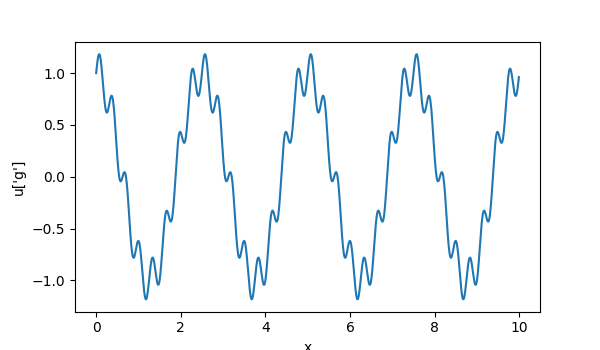

In [8]:
x = dist.local_grid(xbasis)
k0 = 2 *np.pi /Lx
u.change_scales(1)  # Set values on regular grid
u['g'] = np.cos(4 *k0 *x) +0.2 *np.sin(32 *k0 *x)

plt.figure(figsize=(6, 3.5))

plt.plot(x, u['g'])
plt.xlabel('x')
plt.ylabel("u['g']");

We can convert a field to spectral coefficients by requesting its data in coefficient space.
This operation internally triggers an in-place spectral transform of the field’s data.
For the `RealFourier` basis, the coefficients are the interleaved real-valued cosine and (negative) sine coefficients.
The frequencies are expressed relative to the fundamental frequency of the domain.

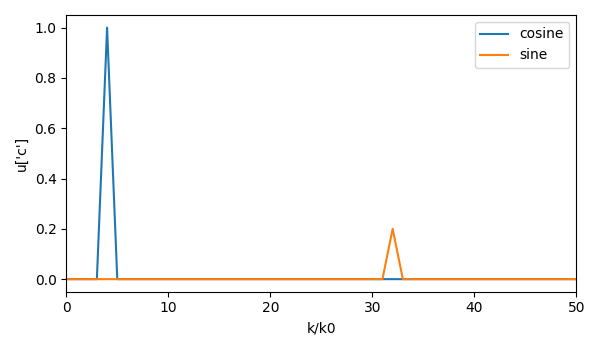

In [9]:
plt.figure(figsize=(6, 3.5))

plt.plot(u['c'][0::2], label='cosine')
plt.plot(-u['c'][1::2], label='sine')

plt.xlabel('k/k0')
plt.ylabel("u['c']")

plt.xlim(0, 50)
plt.legend()
plt.tight_layout()

### 2.2: Operators

Mathematical operations on fields—including arithmetic, differentiation, integration, and interpolation—are represented by `Operator` classes.
An instance of an operator class represents a specific mathematical expression and provides an interface for the deferred evaluation of that expression with respect to its potentially evolving arguments.

Arithmetic operations between fields, or between fields and scalars, can be expressed directly using `Python`’s infix arithmetic operators and `NumPy` universal functions:

In [10]:
v_op = np.exp(1 +2 *u)

print(v_op)

exp(C(1) + 2*u)


The object we obtain is not another field, but an operator object representing the prescribed mathematical operation.
We can visualize the operator as a symbolic graph using a helper function from `dedalus.tools`:

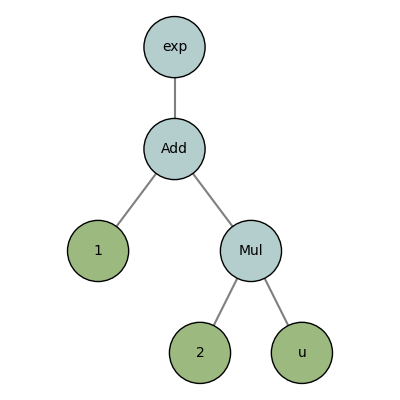

In [11]:
from dedalus.tools.plot_op import plot_operator

plot_operator(v_op, figsize=4, fontsize=10, opsize=0.3)
plt.tight_layout()

To actually compute this operation, we use the operator’s `evaluate` method, which returns a new field containing the result.
The dealiasing scale factors specified during basis instantiation are applied when evaluating all operators, so we must rescale the field back to the regular grid before plotting.

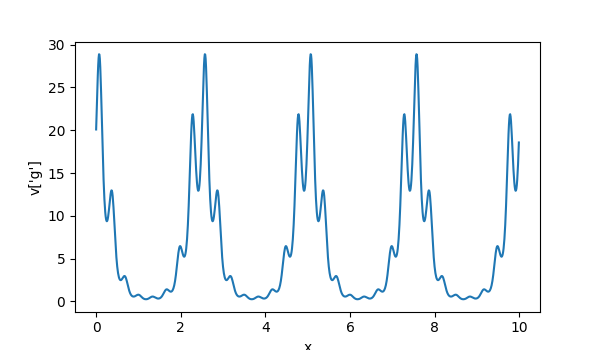

In [12]:
v = v_op.evaluate()
v.change_scales(1)  # View values on regular grid

# Plot grid values
plt.figure(figsize=(6, 3.5))

plt.plot(x, v['g'])

plt.xlabel('x')
plt.ylabel("v['g']");

Partial derivatives in Cartesian coordinates can be computed using the `Differentiate` operator.
Definite integrals, domain averages, and pointwise interpolation are also supported through the `Integrate`, `Average`, and `Interpolate` operators.

For example, we can compute the average value of `v` using these methods, as well as the average value of the derivative of `v` (which, by periodicity, should be zero):

In [13]:
ave = lambda a: d3.Average(a)
dx = lambda a: d3.Differentiate(a, xcoord)

print(ave(v).evaluate()['g'])
print(ave(dx(v)).evaluate()['g'])

[6.44690718]
[0.]


For multidimensional problems, it is more common to use the built-in vector calculus operators, including:

* `Gradient` — for arbitrary fields
* `Divergence` — for vector and tensor fields
* `Curl` — for vector fields
* `Laplacian` — defined as the divergence of the gradient, for arbitrary fields
* `Trace` — for computing the trace of a tensor
* `TransposeComponents` — for transposing tensor indices
* `Symmetrize` — for symmetrizing tensor components
* `VectorPotential` — for constructing a vector potential from a solenoidal field

as well as additional operators for manipulating tensor components.

## 3. Problems and Solvers

`Dedalus` symbolically solves initial value, boundary value, and eigenvalue problems using corresponding Problem and Solver classes.
Here, we will demonstrate how to solve a simple one-dimensional IVP.
For more information on other problem types, see the official [`Dedalus` Tutorial 3](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_3.html).

### 3.1: Problems

Dedalus standardizes the formulation of all initial value problems by expressing systems of symbolically specified equations and boundary conditions in the following generic form:

$$
\mathbf{M} \cdot \partial_t \mathbf{X} + \mathbf{L} \cdot \mathbf{X} = \mathbf{F}(\mathbf{X}, t)
$$

Here, $\mathbf{M}$ and $\mathbf{L}$ are matrices of linear differential operators, $\mathbf{X}$ is a state vector of unknown fields, and $\mathbf{F}$ is a vector of general nonlinear expressions.

The left-hand side (LHS) of the equations must be first order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) may include nonlinear and time-dependent terms, but must not contain temporal derivatives.

To create a problem object, you must provide a list of the field variables to be solved.
You can also pass a dictionary via the `namespace` argument during problem instantiation to make substitutions (operators or functions) available when parsing the equations.
A common practice is to pass `locals()`, which makes all script-level definitions available inside the problem.

Equations can then be specified either as pairs of operator expressions `(LHS, RHS)` or as strings of the form `"LHS = RHS"`.
In addition to the substitutions available through the provided `namespace`, the string parser recognizes all built-in operators as well as common abbreviations for some of them.

As an example, let’s set up Burger’s equation on the domain we have been using so far:

$$
\partial_t u + u \, \partial_x u = a \, \partial_x^2 u
$$


In [14]:
# Parameters
a = 2e-3

# Problem
problem = d3.IVP([u], namespace=locals())
problem.add_equation("dt(u) -a *dx(dx(u)) = -u *dx(u)");

### 3.2: Solvers

Each problem type (IVP, EVP, LBVP, and NLBVP) has a corresponding solver class that carries out the solution steps for that problem.
Solvers are constructed using the `problem.build_solver` method.

For IVPs, a time-stepping method must be specified when building the solver.
Several multistep and Runge–Kutta IMEX schemes are available (see the list in the [timesteppers module](https://dedalus-project.readthedocs.io/en/latest/autoapi/dedalus/core/timesteppers/index.html?utm_source=chatgpt.com)) and can be selected by name.

In [15]:
timestepper = d3.SBDF2
solver = problem.build_solver(timestepper)

2025-10-22 14:43:33,776 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.7e+01/s


For IVPs, stopping criteria for halting time evolution can be specified by setting the attributes `solver.stop_iteration`, `solver.stop_wall_time` (seconds since solver instantiation), and/or `solver.stop_sim_time`.

As an example, let’s stop the simulation at $t = 10$ (in simulation units):

In [16]:
stop_sim_time = 10
solver.stop_sim_time = stop_sim_time

For IVPs and nonlinear BVPs, initial conditions are specified by directly modifying the state variable data before starting the simulation.

In [17]:
# Initial conditions
n = 20
u.change_scales(1)  # Set values on regular grid
u['g'] = np.log(1 +np.cosh(n)**2 /np.cosh(n *(x -0.2 *Lx))**2) /(2 *n)

IVPs are advanced in time using the `solver.step` method with a specified timestep.
The logic controlling the main loop of a `Dedalus` IVP simulation is written explicitly in the simulation script.
The `solver.proceed` property switches from `True` to `False` once any of the stopping criteria have been met.

Let’s advance our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take only a few seconds to run.

In [18]:
# Main loop
timestep = 2e-3

u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]

while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info(f'Iteration={solver.iteration:4d}, Time={solver.sim_time:e}, dt={timestep:e}')
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

2025-10-22 14:43:34,060 __main__ 0/1 INFO :: Iteration= 500, Time=1.000000e+00, dt=2.000000e-03
2025-10-22 14:43:34,263 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2025-10-22 14:43:34,484 __main__ 0/1 INFO :: Iteration=1500, Time=3.000000e+00, dt=2.000000e-03
2025-10-22 14:43:34,698 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03
2025-10-22 14:43:34,901 __main__ 0/1 INFO :: Iteration=2500, Time=5.000000e+00, dt=2.000000e-03
2025-10-22 14:43:35,131 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03
2025-10-22 14:43:35,331 __main__ 0/1 INFO :: Iteration=3500, Time=7.000000e+00, dt=2.000000e-03
2025-10-22 14:43:35,531 __main__ 0/1 INFO :: Iteration=4000, Time=8.000000e+00, dt=2.000000e-03
2025-10-22 14:43:35,740 __main__ 0/1 INFO :: Iteration=4500, Time=9.000000e+00, dt=2.000000e-03
2025-10-22 14:43:36,095 __main__ 0/1 INFO :: Iteration=5000, Time=1.000000e+01, dt=2.000000e-03
2025-10-22 14:43:36,097 solvers 0/1 INFO

Now we can create a space–time plot of the solution:

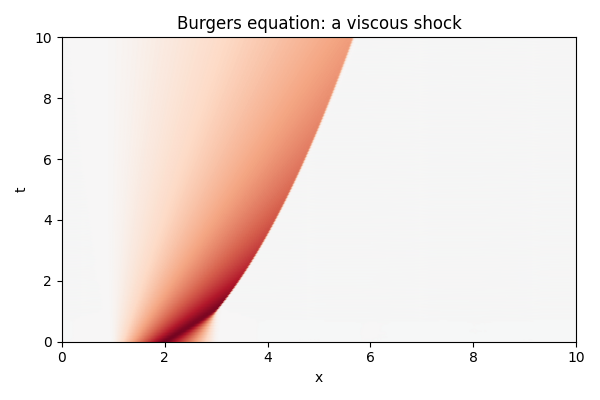

In [19]:
# Plot
plt.figure(figsize=(6, 4))

plt.pcolormesh(x.ravel(), np.array(t_list), np.array(u_list), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))

plt.xlim(0, Lx)
plt.ylim(0, stop_sim_time)

plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Burgers equation: a viscous shock')
plt.tight_layout();

We observe that the solution forms a shock, which is regulated by viscosity.
One might worry that spectral methods do not handle shocks well, but this is only a concern if the physical regulation is not well resolved.
Let’s zoom in on the shock at a particular time to check whether it is properly resolved:

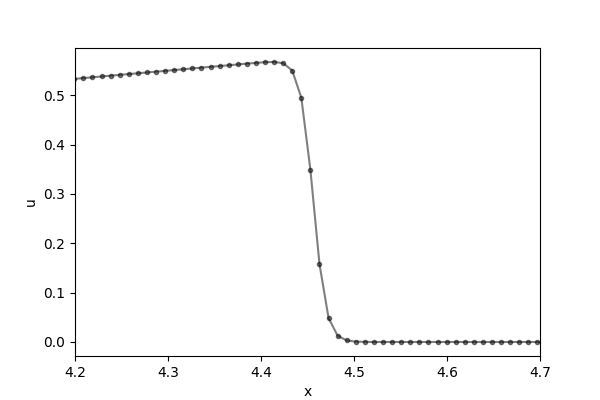

In [20]:
# Plot
plt.figure(figsize=(6, 4))

plt.plot(x.ravel(), u_list[100], '.-k', alpha=0.5)

plt.xlim(4.2, 4.7)

plt.xlabel('x')
plt.ylabel('u');

This looks good!

The real strength of `Dedalus` lies in the flexibility it provides for rapid model iteration and for exploring different equations.
Let’s modify our example by replacing the viscosity term with a dispersive term, and solve the KdV equation instead of Burgers’ equation:

$$
\partial_t u + u \, \partial_x u = b \, \partial_x^3 u
$$

In [21]:
# Parameters
b = 1e-4

# Problem
problem = d3.IVP([u], namespace=locals())
problem.add_equation("dt(u) -b *dx(dx(dx(u))) = -u *dx(u)")

# Initial conditions
n = 20
u['g'] = np.log(1 +np.cosh(n)**2 /np.cosh(n *(x -0.2 *Lx))**2) /(2 *n)

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Main loop
u.change_scales(1)
u_list = [np.copy(u['g'])]
t_list = [solver.sim_time]
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:
        logger.info(f'Iteration={solver.iteration:4d}, Time={solver.sim_time:e}, dt={timestep:e}')
    if solver.iteration % 25 == 0:
        u.change_scales(1)
        u_list.append(np.copy(u['g']))
        t_list.append(solver.sim_time)

2025-10-22 14:43:38,552 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.1e+01/s
2025-10-22 14:43:38,809 __main__ 0/1 INFO :: Iteration= 500, Time=1.000000e+00, dt=2.000000e-03
2025-10-22 14:43:39,056 __main__ 0/1 INFO :: Iteration=1000, Time=2.000000e+00, dt=2.000000e-03
2025-10-22 14:43:39,346 __main__ 0/1 INFO :: Iteration=1500, Time=3.000000e+00, dt=2.000000e-03
2025-10-22 14:43:39,603 __main__ 0/1 INFO :: Iteration=2000, Time=4.000000e+00, dt=2.000000e-03
2025-10-22 14:43:39,855 __main__ 0/1 INFO :: Iteration=2500, Time=5.000000e+00, dt=2.000000e-03
2025-10-22 14:43:40,104 __main__ 0/1 INFO :: Iteration=3000, Time=6.000000e+00, dt=2.000000e-03
2025-10-22 14:43:40,362 __main__ 0/1 INFO :: Iteration=3500, Time=7.000000e+00, dt=2.000000e-03
2025-10-22 14:43:40,601 __main__ 0/1 INFO :: Iteration=4000, Time=8.000000e+00, dt=2.000000e-03
2025-10-22 14:43:40,841 __main__ 0/1 INFO :: Iteration=4500, Time=9.000000e+00, dt=2.000000e-03
2025

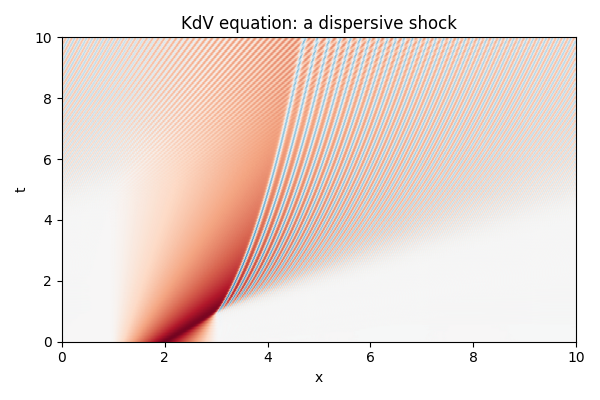

In [22]:
# Plot
plt.figure(figsize=(6, 4))

plt.pcolormesh(x.ravel(), np.array(t_list), np.array(u_list), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))

plt.xlim(0, Lx)
plt.ylim(0, stop_sim_time)

plt.xlabel('x')
plt.ylabel('t')

plt.title(f'KdV equation: a dispersive shock')
plt.tight_layout();